# Generative Adversarial Networks with MXNet GLUON


## Import Dependencies

In [1]:
import os, shutil
from multiprocessing import cpu_count

import matplotlib.pyplot as plt

import numpy as np

import mxnet as mx
from mxnet import ndarray as nd
from mxnet import gluon
from mxnet.gluon.data.vision import transforms
from mxnet import autograd


/Users/kannanva/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Parameters and Hyperparameters

In [2]:
# This is required for dataloader num_process. Fully utilize CPUs to read and transform input data
CPU_COUNT = cpu_count()

# Training Parameters
epochs = 25
batch_size = 10
learning_rate = 0.004
momentum = 0.5

latent_space_dimension = 3* 20*20
image_size = 64
image_channels = 3
image_shape = (image_channels, image_size, image_size)

In [3]:
ctx = mx.cpu() #Use mx.gpu(0) for GPU

## Create Generator and Discriminator Network

In [4]:
# Create Generator Network
class Generator(gluon.Block):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = gluon.nn.Sequential()
        with self.model.name_scope():
            self.model.add(gluon.nn.Conv2DTranspose(in_channels=3, channels=256, kernel_size=3, strides=1))
            self.model.add(gluon.nn.BatchNorm())
            self.model.add(gluon.nn.LeakyReLU(alpha=0.2))
            self.model.add(gluon.nn.Conv2DTranspose(channels=128, kernel_size=3, strides=1))
            self.model.add(gluon.nn.BatchNorm())
            self.model.add(gluon.nn.LeakyReLU(alpha=0.2))
            self.model.add(gluon.nn.Conv2DTranspose(channels=64, kernel_size=3, strides=2))
            self.model.add(gluon.nn.BatchNorm())
            self.model.add(gluon.nn.LeakyReLU(alpha=0.2))
            self.model.add(gluon.nn.Conv2DTranspose(channels=3, kernel_size=3, strides=2))
            self.model.add(gluon.nn.Activation(activation='tanh'))
            self.model.add(gluon.nn.Dense(np.prod(image_shape), activation='tanh'))
    
    def forward(self, X):
        img = self.model(X)
        # Reshape dense layer output to n*3*64*64
        return nd.reshape(img, shape=((X.shape[0],) + image_shape))
        
# Create Discriminator Network
# Discriminator is not so powerful compared to Generator!!
class Discriminator(gluon.Block):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = gluon.nn.Sequential()
        with self.model.name_scope():
            self.model.add(gluon.nn.Conv2D(in_channels=3, channels=64, kernel_size=5, strides=2))
            self.model.add(gluon.nn.LeakyReLU(alpha=0.2))
            self.model.add(gluon.nn.Conv2D(channels=128, kernel_size=5, strides=2))
            self.model.add(gluon.nn.BatchNorm())
            self.model.add(gluon.nn.LeakyReLU(alpha=0.2))
            self.model.add(gluon.nn.Conv2D(channels=256, kernel_size=5, strides=1))
            self.model.add(gluon.nn.BatchNorm())
            self.model.add(gluon.nn.LeakyReLU(alpha=0.2))
            self.model.add(gluon.nn.Conv2D(channels=512, kernel_size=5, strides=1))
            self.model.add(gluon.nn.BatchNorm())
            self.model.add(gluon.nn.LeakyReLU(alpha=0.2))
            self.model.add(gluon.nn.Dense(np.prod(image_shape)))

    
    def forward(self, X):
        img = self.model(X)
        # Reshape dense layer output to n*3*64*64
        return nd.reshape(img, shape=((X.shape[0],) + image_shape))


In [5]:
# Loss Function - Output is Binary (0/1 for Fake/Real) hence BCE Loss
adversarial_loss = gluon.loss.SigmoidBCELoss()

In [6]:
generator = Generator()
discriminator = Discriminator()

generator, discriminator

(Generator(
   (model): Sequential(
     (0): Conv2DTranspose(256 -> 3, kernel_size=(3, 3), stride=(1, 1))
     (1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
     (2): LeakyReLU(0.2)
     (3): Conv2DTranspose(128 -> 0, kernel_size=(3, 3), stride=(1, 1))
     (4): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
     (5): LeakyReLU(0.2)
     (6): Conv2DTranspose(64 -> 0, kernel_size=(3, 3), stride=(2, 2))
     (7): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=None)
     (8): LeakyReLU(0.2)
     (9): Conv2DTranspose(3 -> 0, kernel_size=(3, 3), stride=(2, 2))
     (10): Activation(tanh)
     (11): Dense(None -> 12288, Activation(tanh))
   )
 ), Discriminator(
   (model): Sequential(
     (0): Conv2D(3 -> 64, kernel_size=(5, 5), stride=(2, 2))
     (1): LeakyReLU(0.2)
     (2): Conv2D(None -> 128, kernel_size=(5, 5), stride=(2,

## Initialize Generator and Discriminator Network Parameters

In [7]:
# initialize the generator and the discriminator
generator.initialize(mx.init.Normal(0.02), ctx=ctx, force_reinit=True)
discriminator.initialize(mx.init.Normal(0.02), ctx=ctx)

## Create Trainer for Generator and Discriminator

In [8]:
# trainer for the generator and the discriminator
trainerG = gluon.Trainer(generator.collect_params(), 'sgd', {'learning_rate': learning_rate, 'momentum': momentum})
trainerD = gluon.Trainer(discriminator.collect_params(), 'sgd', {'learning_rate': learning_rate, 'momentum': momentum})

## Prepare Data and Data Loaders

In [9]:
# filelist_path = './data/'
# files = []
# with open(filelist_path + 'filelist.train.txt', 'r') as filelist_f:
#     files = [line.strip() for line in filelist_f]
# if not os.path.isdir("./data/train_images"):
#     os.makedirs('./data/train_images')
# for i, line in enumerate(files):
#     img_path = line.strip()
#     full_path = os.path.join(filelist_path + 'lfwcrop_color/faces', img_path)
#     shutil.copy(full_path, './data/train_images')
# if not os.path.exists('./data/train.rec'):
#     imgs = os.listdir('./data/train_images')
#     record = mx.recordio.MXIndexedRecordIO('./data/train.idx', './data/train.rec', 'w')
#     for i, img in enumerate(imgs):
#         str_img = open('./data/train_images/'+img, 'rb').read()
#         s = mx.recordio.pack((0, i, i, 0), str_img)
#         record.write_idx(i, s)

# files = []
# with open(filelist_path + 'filelist.test.txt', 'r') as filelist_f:
#     files = [line.strip() for line in filelist_f]
# if not os.path.isdir("./data/test_images"):
#     os.makedirs('./data/test_images')
# for i, line in enumerate(files):
#     img_path = line.strip()
#     full_path = os.path.join(filelist_path + 'lfwcrop_color/faces', img_path)
#     shutil.copy(full_path, './data/test_images')
# if not os.path.exists('./data/test.rec'):
#     imgs = os.listdir('./data/test_images')
#     record = mx.recordio.MXIndexedRecordIO('./data/test.idx', './data/test.rec', 'w')
#     for i, img in enumerate(imgs):
#         str_img = open('./data/test_images/'+img, 'rb').read()
#         s = mx.recordio.pack((0, i, i, 0), str_img)
#         record.write_idx(i, s)

In [10]:
def transform(data, label):
    return nd.transpose(data, (2,0,1))/255, label

train_dataset = gluon.data.vision.ImageRecordDataset('./data/train.rec').transform(transform)
train_data = gluon.data.DataLoader(train_dataset, batch_size, shuffle=True, num_workers=CPU_COUNT)

test_dataset = gluon.data.vision.ImageRecordDataset('./data/test.rec').transform(transform)
test_data = gluon.data.DataLoader(test_dataset, batch_size, shuffle=False, num_workers=CPU_COUNT)


## Train the Generator and Discriminator Network

[Epoch - 0] [Batch - 0] - Generator loss = 0.960, Discriminator loss = 0.906
Example fake Generated image


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


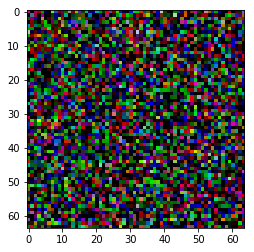

In [ ]:
for e in range(epochs):
    for i, (real_imgs, label) in enumerate(train_data):
        real_imgs = real_imgs.as_in_context(ctx)
        real_imgs = nd.cast(real_imgs, dtype='float32')
        label = label.as_in_context(ctx)
        
        # Adversarial ground truths
        valid = nd.ones(shape=(real_imgs.shape))
        fake = nd.zeros(shape=(real_imgs.shape))
        
        ############## Train Generator ################
        # Sample random noise for Generator Input
#         z = nd.random.normal(loc=0, scale=1, shape=(real_imgs.shape[0], 3, 20, 20))
        z= nd.random.uniform(-1, 1, shape=(real_imgs.shape[0], 3, 20, 20))
        
        with autograd.record():
            gen_imgs = generator(z)
            g_loss = adversarial_loss(discriminator(gen_imgs), valid)
        
        g_loss.backward()
        trainerG.step(real_imgs.shape[0])
        
        ############# Train Discriminator ###############
        with autograd.record():
            real_loss = adversarial_loss(discriminator(real_imgs), valid)
            fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
            d_loss = (real_loss + fake_loss) / 2
        
        d_loss.backward()
        trainerD.step(real_imgs.shape[0])
        
        # Print loss infomation and a fake image every 500 batches
        if i % 500 == 0:
            print('[Epoch - {}] [Batch - {}] - Generator loss = {:.3f}, Discriminator loss = {:.3f}'
                         .format(e, i, nd.mean(g_loss).asscalar(), nd.mean(d_loss).asscalar()))
            print('Example fake Generated image')
            # Choose a random image from generated image
            rand_index = np.random.randint(0, gen_imgs.shape[0])
            plt.imshow(gen_imgs[rand_index].asnumpy().reshape(64,64,3))
            plt.show()